In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import IPython.display as ipyd
import scipy.misc
from libs import utils

import os
content_directory = 'contents/'
style_directory = 'styles/'

# This is the directory to store the final stylized images
output_directory = 'image_output/'
if not os.path.exists(output_directory):
  os.makedirs(output_directory)

# This is the directory to store the half-done images during the training.
checkpoint_directory = 'checkpoint_output/'
if not os.path.exists(checkpoint_directory):
  os.makedirs(checkpoint_directory)


content_name = 'meeting0425.jpg'  # 'wonder-woman.jpg'
style_name = 'rain-princess.jpg'  # 'starry-night.jpg'
output_name = content_name.split('.')[0] + '-' + style_name.split('.')[0]

content_path = os.path.join(content_directory, content_name)   
style_path = os.path.join(style_directory, style_name)
output_path = os.path.join(output_directory, output_name + '-iteration-1000.jpg')

# please notice that the checkpoint_images_path has to contain %s in the file_name
checkpoint_path = os.path.join(checkpoint_directory, output_name + '-iteration-1000-%s.jpg')



content_image = utils.imread(content_path)

# You can pass several style images as a list, but let's use just one for now.
style_images = [utils.imread(style_path)]

In [2]:
import tensorflow as tf
import numpy as np
import scipy.io
import os

VGG_MEAN = [103.939, 116.779, 123.68]

VGG19_LAYERS = (
  'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',

  'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

  'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
  'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

  'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
  'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

  'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
  'relu5_3', 'conv5_4', 'relu5_4'
)


def net_preloaded(input_image, pooling):
  data_dict = np.load('libs/vgg19.npy', encoding='latin1').item()
  net = {}
  current = input_image
  for i, name in enumerate(VGG19_LAYERS):
    kind = name[:4]
    if kind == 'conv':
      kernels = get_conv_filter(data_dict, name)
      # kernels = np.transpose(kernels, (1, 0, 2, 3))

      bias = get_bias(data_dict, name)
      # matconvnet: weights are [width, height, in_channels, out_channels]
      # tensorflow: weights are [height, width, in_channels, out_channels]

      # bias = bias.reshape(-1)
      current = conv_layer(current, kernels, bias)
    elif kind == 'relu':
      current = tf.nn.relu(current)
    elif kind == 'pool':
      current = pool_layer(current, pooling)

    net[name] = current

  assert len(net) == len(VGG19_LAYERS)
  return net

def conv_layer(input, weights, bias):
  conv = tf.nn.conv2d(input, weights, strides=(1, 1, 1, 1), padding='SAME')
  return tf.nn.bias_add(conv, bias)


def pool_layer(input, pooling):
  if pooling == 'avg':
    return tf.nn.avg_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
            padding='SAME')
  else:
    return tf.nn.max_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
            padding='SAME')

# before we feed the image into the network, we preprocess it by 
# extracting the mean_pixel from it.
def preprocess(image):
  return image - VGG_MEAN

# remember to unprocess it before you plot it out and save it.
def unprocess(image):
  return image + VGG_MEAN

def get_conv_filter(data_dict, name):
  return tf.constant(data_dict[name][0], name="filter")

def get_bias(data_dict, name):
  return tf.constant(data_dict[name][1], name="biases")

In [3]:
import tensorflow as tf
import numpy as np
from functools import reduce
from PIL import Image

## ----------- ----------- ----------- ----------- ----------- -----------

VGG19_LAYERS = (

    'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',

    'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

    'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
    'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

    'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
    'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

    'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
    'relu5_3', 'conv5_4', 'relu5_4'
)


## 用 dictionary 的方式回傳整個 network
def net_preloaded(input_image, pooling):
    data_dict = np.load('libs/vgg19.npy', encoding='latin1').item()
    net = {}
    current = input_image
    for i, name in enumerate(VGG19_LAYERS):
        kind = name[:4]
        if kind == 'conv':
            kernels = get_conv_filter(data_dict, name)
            # kernels = np.transpose(kernels, (1, 0, 2, 3))

            bias = get_bias(data_dict, name)
            # matconvnet: weights are [width, height, in_channels, out_channels]
            # tensorflow: weights are [height, width, in_channels, out_channels]

            # bias = bias.reshape(-1)
            current = conv_layer(current, kernels, bias)
        elif kind == 'relu':
            current = tf.nn.relu(current)
        elif kind == 'pool':
            current = pool_layer(current, pooling)

        net[name] = current

    assert len(net) == len(VGG19_LAYERS)
    return net

## ----------- ----------- ----------- ----------- ----------- -----------


## start from here ! ##

## 先設定好要取用哪些層作為 CONTENT_LAYERS & STYLE_LAYERS
# feel free to try different layers
CONTENT_LAYERS = ('relu4_2', 'relu5_2')
STYLE_LAYERS = ('relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1')

VGG_MEAN = [103.939, 116.779, 123.68]

def stylize(content, styles, network_path='libs/imagenet-vgg-verydeep-19.mat',
            iterations=1000, content_weight=5e0, content_weight_blend=0.5, style_weight=5e2,
            style_layer_weight_exp=1, style_blend_weights=None, tv_weight=100,
            learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
            print_iterations=100, checkpoint_iterations=100, checkpoint_path=None,
            output_path=None):


    shape = (1,) + content.shape                             # content image shape : (1, 433, 770, 3)
    style_shapes = [(1,) + style.shape for style in styles]  # style image shape : (1, 600, 800, 3)
    content_features = {}
    style_features = [{} for _ in styles]


    ## 取出每一層指定 STYLE_LAYERS 的 weight, 並看要不要
    # scale the importance of each style layers according to their depth. 
    # (deeper layers are more important if style_layers_weights > 1 (default = 1))
    layer_weight = 1.0
    style_layers_weights = {}                                # weight for different network layers
    for style_layer in STYLE_LAYERS:
        style_layers_weights[style_layer] = layer_weight       #'relu1_1','relu2_1',...,'relu5_1'
        layer_weight *= style_layer_weight_exp                 # 1.0


    ## 對每一層 style layer 的 weights 做 normalize
    # normalize style layer weights
    layer_weights_sum = 0
    for style_layer in STYLE_LAYERS:                         #'relu1_1',..., 'relu5_1'
        layer_weights_sum += style_layers_weights[style_layer] # 5.0
    for style_layer in STYLE_LAYERS:
        style_layers_weights[style_layer] /= layer_weights_sum


    ## 算出 content_image 進入 model 後, 在每一層 CONTENT_LAYERS 的輸出, 存在 content_features
    # FEATURE MAPS FROM CONTENT IMAGE
    # compute the feature map of the content image by feeding it into the network
    # the output net contains the features of each content layer
    g = tf.Graph()
    with g.as_default(), tf.Session() as sess:
        image = tf.placeholder('float', shape=shape)

        net = net_preloaded(image, pooling)             # {'conv1_1':Tensor,relu1_1:Tensor...}
        content_pre = np.array([preprocess(content)])   # (1,433,770,3) subtract the mean pixel
        for layer in CONTENT_LAYERS:                    # 'relu4_2', 'relu5_2'
            content_features[layer] = net[layer].eval(feed_dict={image: content_pre})


    ## 將 style image 輸入後, 每一層 STYLE LAYER 的 output 轉換成 gram matrix
    ## gram matrix: 把每一張 filter 掃出來的 feature maps 拉直, 自乘成一個二維矩陣

    # FEATURE MAPS (GRAM MATRICES) FROM STYLE IMAGE
    # compute style features of the style image by feeding it into the network
    # and calculate the gram matrix
    for i in range(len(styles)):
        g = tf.Graph()
        with g.as_default(), tf.Session() as sess:
            image = tf.placeholder('float', shape=style_shapes[i])
            net = net_preloaded(image, pooling)
            style_pre = np.array([preprocess(styles[i])])
            for layer in STYLE_LAYERS:              #'relu1_1', 'relu2_1',..., 'relu5_1'
                features = net[layer].eval(feed_dict={image: style_pre})  # relu_1:(1,600,800,64)
                features = np.reshape(features, (-1, features.shape[3]))  # (480000, 64)
                gram = np.matmul(features.T, features) / features.size    # (64,64)
                style_features[i][layer] = gram


    ## 前面的部分, 是在取出特定 layer (CONTENT_LAYERS & STYLE_LAYERS) 的 weight, 或是圖片進去後該層的 output
    ## 並存在 content_features & style_features 中

    ## -- 下面開始才是主要的 graph (network) --

    # make stylized image using backpropogation
    with tf.Graph().as_default():

        ## 隨機生成 image
        # Generate a random image (the output image) with the same shape as the content image
        initial = tf.random_normal(shape) * 0.256
        image = tf.Variable(initial)
        net = net_preloaded(image, pooling)

        ## 這邊隨機生成這張圖片 (image), 就是最後要輸出的圖片
        ## 他不是用 placeholder, 而是用 variable ! 
        ## 所以等等更新回來的時候, 會一路更新回到圖片上  
        ## (很像這個圖片也是 weight 的感覺, 每次執行 train_step 他都會被更新)

        ## 而現在這個 net 也才是最主要的 network (講義圖片中間的那個)


        ## 計算隨機生成的 image 的 content_loss

        # CONTENT LOSS
        # we can adjust the weight of each content layers
        # content_weight_blend is the ratio of two used content layers in this example
        content_layers_weights = {}
        content_layers_weights['relu4_2'] = content_weight_blend
        content_layers_weights['relu5_2'] = 1.0 - content_weight_blend

        content_loss = 0
        content_losses = []

        ## 上面給的一些預設值
        # CONTENT_LAYERS = ('relu4_2', 'relu5_2')
        # content_weight = 5e0 (= 5.0)

        # content_layers_weights: 上面幾行設定的, 給每一層的一個權重
        # content_features: image 經過 content layer 後的輸出 (feature map)


        ## loss 的部分
        ## 都是在看現在主要的 net (講義中間), 跟左右兩邊, 在特定層上面 output 的差異
        
        ## L2-norm loss: output = sum(input ** 2) / 2

        for content_layer in CONTENT_LAYERS:   
            # Use MSE as content losses
            # content weight is the coefficient for content loss
            content_losses.append(
                                    content_layers_weights[content_layer] * content_weight *
                                    (2 * tf.nn.l2_loss(net[content_layer] - content_features[content_layer]) /
                                    content_features[content_layer].size)
                                )
        content_loss += reduce(tf.add, content_losses)
        ## 最後所有 content_loss SUM 起來


        ## 計算隨機生成的 image 的 style_loss

        # STYLE LOSS
        # We can specify different weight for different style images
        # style_layers_weights => weight for different network layers
        # style_blend_weights => weight between different style images

        if style_blend_weights is None:
            style_blend_weights = [1.0/len(style_images) for _ in style_images]
        else:
            total_blend_weight = sum(style_blend_weights)
            # normalization
            style_blend_weights = [weight/total_blend_weight for weight in style_blend_weights]


        style_loss = 0
        # iterate to calculate style loss with multiple style images
        for i in range(len(styles)):
            style_losses = []
            for style_layer in STYLE_LAYERS:                    # e.g. relu1_1
                layer = net[style_layer]                        # relu1_1 of output image:(1,433,770,64)
                _, height, width, number = map(lambda i: i.value, layer.get_shape())
                size = height * width * number
                feats = tf.reshape(layer, (-1, number))         # (333410,64)

                # Gram matrix for the features in relu1_1 of the output image.
                gram = tf.matmul(tf.transpose(feats), feats) / size
                # Gram matrix for the features in relu1_1 of the style image
                style_gram = style_features[i][style_layer]


                ## 這邊 style loss 的計算和上面很像
                ## 差別只在於, 剛剛是在算指定層的 output, 現在改成算 指定層的 output 的 `gram_matrix` 
                ##                                                              (再多經過一個轉換而已)

                # Style loss is the MSE for the difference of the 2 Gram matrices
                style_losses.append(    style_layers_weights[style_layer] * 2 *
                                        tf.nn.l2_loss(gram - style_gram) / style_gram.size    )

            style_loss += style_weight * style_blend_weights[i] * reduce(tf.add, style_losses)

        ## style_weight: 5e2 (500)




        # TOTAL VARIATION LOSS  

        ## 這裡比講義上面的解說圖片, 還多算了一種 loss
        ## 他是拿鄰近的 pixel 算 loss...
        ## (在算同一張圖片, 上下平移一格 或是左右平移一格 的 loss)

        # Total variation denoising to do smoothing; cost to penalize neighboring pixel
        # not used by the original paper by Gatys et al
        # According to the paper Mahendran, Aravindh, and Andrea Vedaldi. "Understanding deep 
        # image representations by inverting them."
        # Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition. 2015.
        tv_y_size = _tensor_size(image[:,1:,:,:])
        tv_x_size = _tensor_size(image[:,:,1:,:])
        tv_loss = tv_weight * 2 * (
                                    (tf.nn.l2_loss(image[:,1:,:,:] - image[:,:shape[1]-1,:,:]) / tv_y_size) +
                                    (tf.nn.l2_loss(image[:,:,1:,:] - image[:,:,:shape[2]-1,:]) / tv_x_size)
                                  )

        ## tv_weight: 100


        # OVERALL LOSS

        ## 最後把三種 loss 加總, 更新這個 loss
        ## content_weight, style_weight, tv_weight 這三個權重應該都寫在這邊, 加總的時候再乘權重比較好

        loss = content_loss + style_loss + tv_loss


        ## 下面執行 train_step 來 minimize loss
        ## 全部的運算都只更新主要 net (講義圖片中間的部分)

        ## 這裡特殊的地方在他不僅更新 network 的參數, 還更新回去生成的圖片上

        train_step = tf.train.AdamOptimizer(learning_rate, beta1, beta2, epsilon).minimize(loss)


        def print_progress():
            print('======================================================\n')
            print('     iteration: %d' % i)
            print('  content loss: %g' % content_loss.eval())
            print('    style loss: %g' % style_loss.eval())
            print('       tv loss: %g' % tv_loss.eval())
            print('    total loss: %g\n' % loss.eval())
        
        def imsave(path, img):
            img = np.clip(img, 0, 255).astype(np.uint8)
            Image.fromarray(img).save(path, quality=95)



        # TRAINING
        best_loss = float('inf')
        best = None

        with tf.Session() as sess:

            sess.run(tf.global_variables_initializer())

            if (print_iterations and print_iterations != 0):
                print_progress()

            for i in range(iterations):

                train_step.run()    ## run here

                last_step = (i == iterations - 1)
                if last_step or (print_iterations and i % print_iterations == 0):
                    print_progress()

                # store output and checkpoint images
                if (checkpoint_iterations and i % checkpoint_iterations == 0) or last_step:
                    this_loss = loss.eval()
                    if this_loss < best_loss:
                        best_loss = this_loss
                        best = image.eval()

                    img_out = unprocess(best.reshape(shape[1:]))

                    output_file = None
                    if not last_step:
                        if checkpoint_path:
                                output_file = checkpoint_path % i
                    else:
                        output_file = output_path

                    if output_file:
                        imsave(output_file, img_out)

    print("finish stylizing.\n")



def _tensor_size(tensor):
    from operator import mul
    return reduce(mul, (d.value for d in tensor.get_shape()), 1)

In [4]:
%%time

checkpoint_path=None
output_path='image_output/' + output_name + '-tvweight-100.jpg'

stylize(content_image, style_images, iterations=1000,
        content_weight=5e0, content_weight_blend=1, style_weight=5e2,
        style_layer_weight_exp=1, style_blend_weights=None, tv_weight=100,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)


     iteration: 0
  content loss: 347895
    style loss: 1.05196e+07
       tv loss: 26.2067
    total loss: 1.08675e+07


     iteration: 0
  content loss: 318065
    style loss: 9.79262e+06
       tv loss: 14601.4
    total loss: 1.01253e+07


     iteration: 100
  content loss: 284294
    style loss: 91660.2
       tv loss: 55117.7
    total loss: 431072


     iteration: 200
  content loss: 232908
    style loss: 61518.7
       tv loss: 48130.8
    total loss: 342558


     iteration: 300
  content loss: 212116
    style loss: 51272.1
       tv loss: 45276.3
    total loss: 308664


     iteration: 400
  content loss: 212336
    style loss: 45078.1
       tv loss: 44425.5
    total loss: 301839


     iteration: 500
  content loss: 210100
    style loss: 41398.8
       tv loss: 43556.8
    total loss: 295056


     iteration: 600
  content loss: 197504
    style loss: 42049.4
       tv loss: 41792.3
    total loss: 281346


     iteration: 700
  content loss: 204353
    style loss

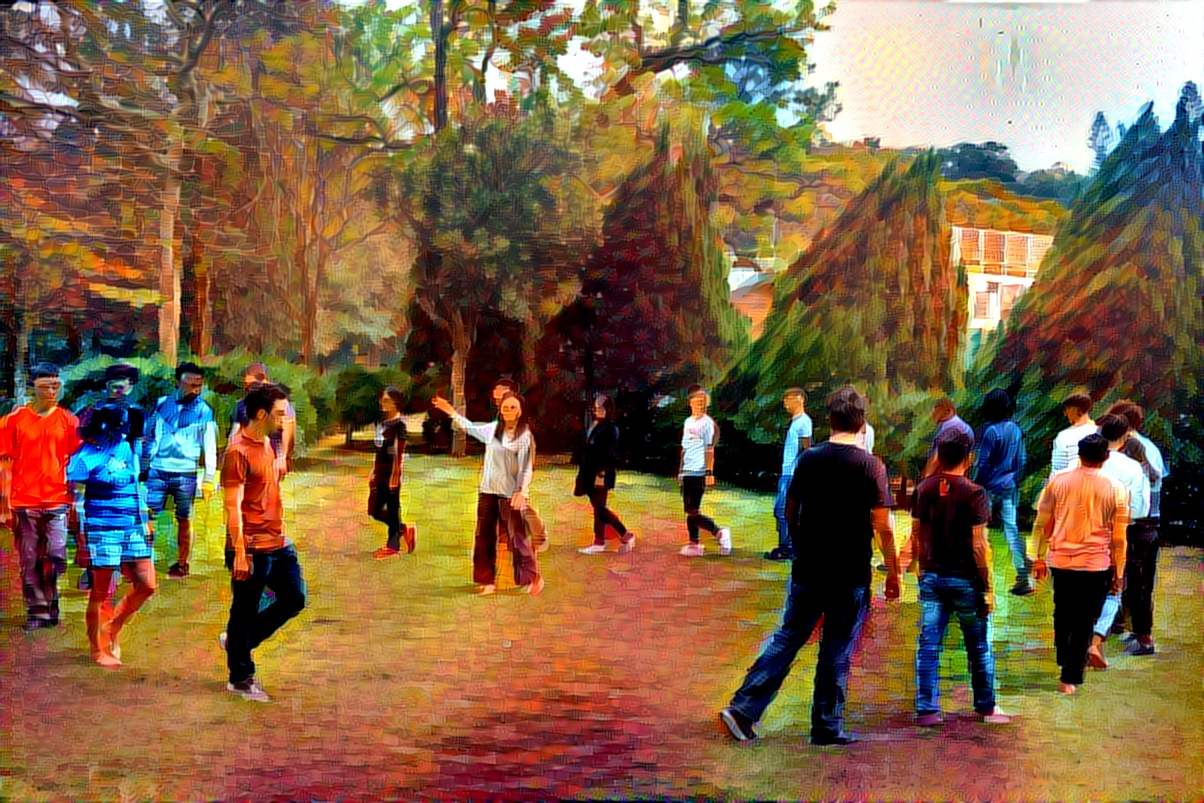

In [5]:
from IPython.display import Image
Image(output_path)

